In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import numpy as np
import time
import xarray as xr
import random

In [2]:
os.getcwd()

'/home/bouissob/Code'

In [3]:
def Make_dire(file_path):
    if not os.path.isdir(file_path):
        os.makedirs(file_path)

In [4]:
Bet_path = '/bettik/bouissob/'

files = glob(os.path.join(Bet_path, 'Data/') + '*Ocean1*')

In [5]:
pd.read_csv(files[0]).head()

,y,x,meltRate,thermalDriving,halineDriving,iceDraft,date,temperatureYZ,salinityYZ
0,0,194,1.445518e-09,0.009086,0.127754,82.815510,0,-1.900030,33.893150
1,0,316,2.533100e-09,0.013837,0.194261,91.276440,0,-1.900030,33.893150
2,2,194,1.421181e-09,0.008926,0.125516,81.651650,0,-1.900036,33.892456
3,2,294,2.025993e-09,0.012627,0.177358,89.908270,0,-1.900036,33.892456
4,2,296,1.932426e-09,0.012012,0.168752,90.281364,0,-1.900036,33.892456


In [6]:
multi = 1
if multi == 1:
    Datas = glob(Bet_path + '/Data/*S.csv')
    Clean_Data = pd.DataFrame()
    li = []
    for ind, d in enumerate(Datas):
        print('{}/{}'.format(ind, len(Datas)))
        #data = pd.read_csv(d)
        print(d)
        li.append(pd.read_csv(d))
    Clean_Data = pd.concat(li,ignore_index = True)
    del li
else:
    Datas = glob(Bet_path + '/Data/*Ocean1*.csv')
    Data = pd.read_csv(Datas[0])
    Clean_Data = Data.dropna()
    Clean_Data.reset_index(inplace=True, drop = True)


0/4
/bettik/bouissob//Data/data_Ocean1_COM_NEMO-CNRS.csv
1/4
/bettik/bouissob//Data/data_Ocean2_COM_NEMO-CNRS.csv
2/4
/bettik/bouissob//Data/data_Ocean3_COM_NEMO-CNRS.csv
3/4
/bettik/bouissob//Data/data_Ocean4_COM_NEMO-CNRS.csv


In [7]:
Cols = Clean_Data.columns
Var_names_X = Cols.drop(['date', 'meltRate'])
Var_names_X = Cols.drop(['date', 'meltRate', 'halineDriving', 'thermalDriving'])

In [8]:
X = Clean_Data[Var_names_X]
Y = Clean_Data['meltRate']
X_train = X.sample(frac = 0.8)
X_valid = X.drop(X_train.index)

Y_train = Y.loc[X_train.index]
Y_valid = Y.drop(X_train.index)
print(len(X_train), len(X_valid))

mean, std = X_train.mean(), X_train.std() 
meanY, stdY = Y_train.mean(), Y_train.std() 
X_train, X_valid = (np.array((X_train - mean)/std), 
                    np.array((X_valid - mean)/std))

Y_train, Y_valid = (np.array((Y_train - meanY)/stdY), 
                    np.array((Y_valid - meanY)/stdY))

del X, Y
del Clean_Data
#maxX, minX = X_train.max(), X_train.min()
#maxY, minY = Y_train.max(), Y_train.min()
#X_train, X_valid = np.array((X_train - minX)/(maxX - minX)), np.array((X_valid - minX)/(maxX - minX))
#Y_train, Y_valid = np.array((Y_train - minY)/(maxY - minY)), np.array((Y_valid - minY)/(maxY - minY))
#Y_train_N, Y_valid_N = np.array(Y_train / maxY), np.array(Y_valid/maxY)

7483133 1870783


In [13]:
def Model_init(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam',
                 loss = 'mse',
                metrics = ['mae', 'mse'])
    return model
def Model_init2(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape))
    model.add(tf.keras.layers.Dense(32, activation = 'swish'))
    model.add(tf.keras.layers.Dense(64, activation = 'swish'))
    model.add(tf.keras.layers.Dense(64, activation = 'swish'))
    model.add(tf.keras.layers.Dense(32, activation = 'swish'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam',
                 loss = 'mse',
                metrics = ['mae', 'mse'])
    return model

In [14]:
if len(Datas) ==1:
    Temp = Datas[0].split('/')
    Name = Temp[len(Temp) - 1]
    Name = Name.replace('data_', '')
    Ocean_scen = Name.split('_')[0]
    Mod_nam = Name.replace(Ocean_scen + '_', '').split('.')[0]
else:
    Names = []
    for n in Datas:
        Temp = n.split('/')
        Name = Temp[len(Temp) - 1]
        Name = Name.replace('data_', '')
        Ocean_scens = Name.split('_')[0]
        Names.append(Ocean_scens)
    Ocean_scen = '_'.join(Names)
    Mod_nam = Name.replace(Ocean_scens + '_', '').split('.')[0]
        

In [16]:
Ocean_scen

'Ocean1_Ocean2_Ocean3_Ocean4'

In [17]:
Model_path = '/'.join([os.getcwd(),'Models',Mod_nam, Ocean_scen])

In [18]:
Model_path

'/home/bouissob/Code/Models/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4'

In [ ]:
Nbr_Epoch = 3

Uniq = time.time()

Name ='Ep_{}_Input_{}_{}'.format(Nbr_Epoch, len(Var_names_X), Uniq)
filepath = Model_path + '/' + Name + '/'
Make_dire(filepath)
#maxX.to_pickle(filepath + 'MaxX.pkl')
#minX.to_pickle(filepath + 'MinX.pkl')
#np.savetxt(filepath + 'MaxY.csv', np.array(maxY).reshape(1, ))
#np.savetxt(filepath + 'MinY.csv', np.array(minY).reshape(1, ))

mean.to_pickle(filepath + 'MeanX.pkl')
std.to_pickle(filepath + 'StdX.pkl')
np.savetxt(filepath + 'MeanY.csv', np.array(meanY).reshape(1, ))
np.savetxt(filepath + 'StdY.csv', np.array(stdY).reshape(1, ))

model = Model_init( (len(Var_names_X), ))
Model = model.fit(X_train, Y_train,
                   epochs = Nbr_Epoch,
                   batch_size = 64,
                   validation_data = (X_valid, Y_valid))
Model_path = os.getcwd() + '/Models/' + Mod_nam + '/' + Ocean_scen + '/'
model.save(filepath + 'model.h5')
del X_train, Y_train
del X_valid, Y_valid

2022-02-24 11:02:41.089959: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-24 11:02:41.132641: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 11:02:41.147028: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-24 11:02:42.017837: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-24 11:02:42.119042: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499985000 Hz


Epoch 1/3
116924/116924 [==============================] - 277s 2ms/step - loss: 0.0728 - mae: 0.0731 - mse: 0.0728 - val_loss: 0.0286 - val_mae: 0.0479 - val_mse: 0.0286
Epoch 2/3
  4784/116924 [>.............................] - ETA: 3:35 - loss: 0.0363 - mae: 0.0506 - mse: 0.0363

In [ ]:
Datas = glob(os.getcwd() + '/Data/*.nc.csv')
Data = pd.read_csv(Datas[0])
Clean_Data = Data.dropna()
Clean_Data.reset_index(inplace=True)

/home/bouissob/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


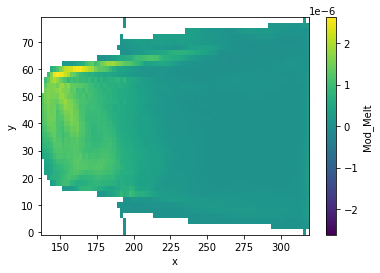

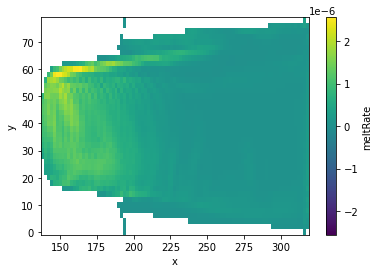

In [50]:
Data = Clean_Data.loc[Clean_Data.date == 200]
X = Data[Var_names_X]
X = np.array((X - mean)/std)
X = np.array(X).reshape(-1, 5, )
Y_mod = Model.model(X)
#Data['Mod_Melt'] = Y_mod.numpy().reshape(len(Y_mod, )) * maxY
Data['Mod_Melt'] = (Y_mod.numpy().reshape(len(Y_mod, )) * stdY) + meanY
Dataset = Data.set_index(['y', 'x'])
Dataset = Dataset.to_xarray()
Dataset.Mod_Melt.plot(cmap = plt.get_cmap('viridis'))
plt.figure()
Dataset.meltRate.plot(cmap = plt.get_cmap('viridis'))

In [51]:
mean

y                 39.005011
x                236.900218
iceDraft         246.779432
temperatureYZ     -1.530660
salinityYZ        34.014723
dtype: float64

In [54]:
Var_names_X

Index(['y', 'x', 'iceDraft', 'temperatureYZ', 'salinityYZ'], dtype='object')

In [52]:
std

y                 19.342531
x                 50.339525
iceDraft         118.747140
temperatureYZ      0.648915
salinityYZ         0.214172
dtype: float64

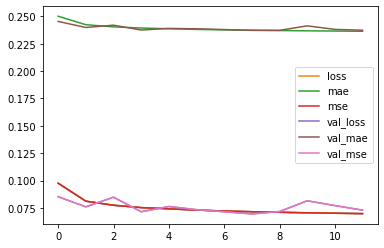

In [18]:
hist = Model.history
plt.plot(hist['loss'])
for k in hist.keys():
    plt.plot(hist[k], label = k)
plt.legend()
plt.show()